Using the Northwind database, an open-source dataset created by Microsoft, this Jupyter notebook will do some exploratory data analysis and use hypothesis testing to dive deep into four questions:
1. Do discounts have a statistically significant effect on the number of products customers order? If so, at what level(s) of discount?
2. Do discounts have a statistically significant effect on the dollar value of orders?
3. Do older customers have statistically significant larger value orders?
4. 


Step 1: Import the libraries used.

In [4]:
#imports
import sqlalchemy
from sqlalchemy import create_engine
from sqlalchemy.orm import Session, sessionmaker
from sqlalchemy import inspect

import numpy as np
import pandas as pd
import matplotlib as plt
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from math import sqrt
import scipy.stats as stats
from sklearn import preprocessing

from datetime import datetime

Step 1: Create an sqalchemy "engine" to query the database tables.

In [6]:
# create the SQL engine
# optinal - to use the large version of the databse, use this to create the SQL engine:
# engine = create_engine('sqlite:///Northwind_large.sqlite', echo=True)

# using the small version of the databse:
engine = create_engine('sqlite:///Northwind_small.sqlite', echo=True)
con = engine.connect()
Session = sessionmaker(bind=engine)
session = Session()

2019-05-10 14:41:53,635 INFO sqlalchemy.engine.base.Engine SELECT CAST('test plain returns' AS VARCHAR(60)) AS anon_1
2019-05-10 14:41:53,638 INFO sqlalchemy.engine.base.Engine ()
2019-05-10 14:41:53,641 INFO sqlalchemy.engine.base.Engine SELECT CAST('test unicode returns' AS VARCHAR(60)) AS anon_1
2019-05-10 14:41:53,643 INFO sqlalchemy.engine.base.Engine ()


In [8]:
# have a look at the various tables
inspector = inspect(engine)
print(inspector.get_table_names())

2019-05-10 14:42:28,610 INFO sqlalchemy.engine.base.Engine SELECT name FROM sqlite_master WHERE type='table' ORDER BY name
2019-05-10 14:42:28,612 INFO sqlalchemy.engine.base.Engine ()
['Category', 'Customer', 'CustomerCustomerDemo', 'CustomerDemographic', 'Employee', 'EmployeeTerritory', 'Order', 'OrderDetail', 'Product', 'Region', 'Shipper', 'Supplier', 'Territory']


There are 13 tables. This chart shows the relationships between the tables.
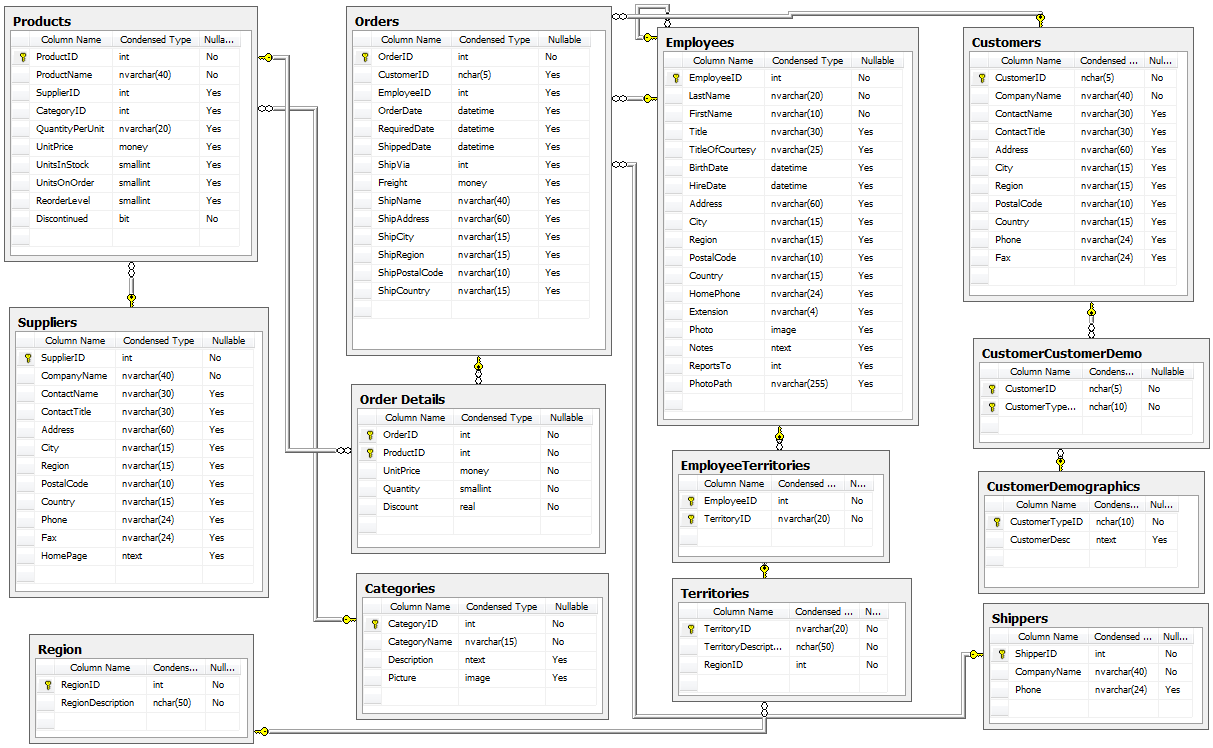

As I will be creating multiple pandas dataframes from the sql tables, I need a function that will return the column names from an SQL table.

In [10]:
def get_columns_info(col_name):
    cols_list = inspector.get_columns(col_name)
    
    print("Table Name: {}".format(col_name))
    print("")
    
    for column in cols_list:
        print("Name: {} \t Type: {}".format(column['name'], column['type']))

In [12]:
#function to return a list of the column names from table given as an argument
def make_column_list(table):
    cols = []  #make an empty list
    cols_dict = inspector.get_columns(table)  # make a dict of the column names from the SQL table
#     print(cols_list)
    for column in cols_dict:
        cols.append(column['name'])
#     print(cols)
    return cols

In [13]:
# crate a pandas dataframe of the OrderDetail table
rs = con.execute('SELECT * FROM OrderDetail')
order_detail = pd.DataFrame(rs.fetchall())

column_names = make_column_list('OrderDetail')
order_detail.columns = column_names

order_detail.head()

2019-05-10 22:28:19,362 INFO sqlalchemy.engine.base.Engine SELECT * FROM OrderDetail
2019-05-10 22:28:19,365 INFO sqlalchemy.engine.base.Engine ()
2019-05-10 22:28:19,382 INFO sqlalchemy.engine.base.Engine PRAGMA table_info("OrderDetail")
2019-05-10 22:28:19,384 INFO sqlalchemy.engine.base.Engine ()


,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10248/11,10248,11,14.0,12,0.0
1,10248/42,10248,42,9.8,10,0.0
2,10248/72,10248,72,34.8,5,0.0
3,10249/14,10249,14,18.6,9,0.0
4,10249/51,10249,51,42.4,40,0.0


In [14]:
# customer table to a pandas dataframe
rs = con.execute('SELECT * FROM Customer')
customers = pd.DataFrame(rs.fetchall())
column_names = make_column_list('Customer')
customers.columns = column_names

customers.head(10)

2019-05-10 22:28:24,251 INFO sqlalchemy.engine.base.Engine SELECT * FROM Customer
2019-05-10 22:28:24,254 INFO sqlalchemy.engine.base.Engine ()
2019-05-10 22:28:24,260 INFO sqlalchemy.engine.base.Engine PRAGMA table_info("Customer")
2019-05-10 22:28:24,262 INFO sqlalchemy.engine.base.Engine ()


,Id,CompanyName,ContactName,ContactTitle,Address,City,Region,PostalCode,Country,Phone,Fax
0,ALFKI,Alfreds Futterkiste,Maria Anders,Sales Representative,Obere Str. 57,Berlin,Western Europe,12209,Germany,030-0074321,030-0076545
1,ANATR,Ana Trujillo Emparedados y helados,Ana Trujillo,Owner,Avda. de la Constitución 2222,México D.F.,Central America,05021,Mexico,(5) 555-4729,(5) 555-3745
2,ANTON,Antonio Moreno Taquería,Antonio Moreno,Owner,Mataderos 2312,México D.F.,Central America,05023,Mexico,(5) 555-3932,None
3,AROUT,Around the Horn,Thomas Hardy,Sales Representative,120 Hanover Sq.,London,British Isles,WA1 1DP,UK,(171) 555-7788,(171) 555-6750
4,BERGS,Berglunds snabbköp,Christina Berglund,Order Administrator,Berguvsvägen 8,Luleå,Northern Europe,S-958 22,Sweden,0921-12 34 65,0921-12 34 67
5,BLAUS,Blauer See Delikatessen,Hanna Moos,Sales Representative,Forsterstr. 57,Mannheim,Western Europe,68306,Germany,0621-08460,0621-08924
6,BLONP,Blondesddsl père et fils,Frédérique Citeaux,Marketing Manager,"24, place Kléber",Strasbourg,Western Europe,67000,France,88.60.15.31,88.60.15.32
7,BOLID,Bólido Comidas preparadas,Martín Sommer,Owner,"C/ Araquil, 67",Madrid,Southern Europe,28023,Spain,(91) 555 22 82,(91) 555 91 99
8,BONAP,Bon app,Laurence Lebihan,Owner,"12, rue des Bouchers",Marseille,Western Europe,13008,France,91.24.45.40,91.24.45.41
9,BOTTM,Bottom-Dollar Markets,Elizabeth Lincoln,Accounting Manager,23 Tsawassen Blvd.,Tsawassen,North America,T2F 8M4,Canada,(604) 555-4729,(604) 555-3745


In [15]:
# get full orders
rs = con.execute('SELECT * FROM [Order]')
orders = pd.DataFrame(rs.fetchall())

column_names = make_column_list('Order')
orders.columns = column_names

orders.head()

2019-05-10 22:29:24,028 INFO sqlalchemy.engine.base.Engine SELECT * FROM [Order]
2019-05-10 22:29:24,031 INFO sqlalchemy.engine.base.Engine ()
2019-05-10 22:29:24,046 INFO sqlalchemy.engine.base.Engine PRAGMA table_info("Order")
2019-05-10 22:29:24,048 INFO sqlalchemy.engine.base.Engine ()


,Id,CustomerId,EmployeeId,OrderDate,RequiredDate,ShippedDate,ShipVia,Freight,ShipName,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry
0,10248,VINET,5,2012-07-04,2012-08-01,2012-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France
1,10249,TOMSP,6,2012-07-05,2012-08-16,2012-07-10,1,11.61,Toms Spezialitäten,Luisenstr. 48,Münster,Western Europe,44087,Germany
2,10250,HANAR,4,2012-07-08,2012-08-05,2012-07-12,2,65.83,Hanari Carnes,"Rua do Paço, 67",Rio de Janeiro,South America,05454-876,Brazil
3,10251,VICTE,3,2012-07-08,2012-08-05,2012-07-15,1,41.34,Victuailles en stock,"2, rue du Commerce",Lyon,Western Europe,69004,France
4,10252,SUPRD,4,2012-07-09,2012-08-06,2012-07-11,2,51.30,Suprêmes délices,"Boulevard Tirou, 255",Charleroi,Western Europe,B-6000,Belgium


After some errors during EDA I discovered some orders with CustomerId's that did not exist in the Customers table:
* ANTO
* DUMO
* OCEA
* QUEE

Upon inspection of the Customers table, it appears that the above Id's are all missing an "N" at the end of the Id. As customer Id's have 5 letters except these 4, so I chose to assign these orders to the what reasonably appears to be the correct Customer, assuming that the last letter had somehow been deleted. 

In [16]:
# correct the incorect CustomerId values in orders_count
orders['CustomerId'].replace('ANTO', 'ANTON', inplace=True)
orders['CustomerId'].replace('DUMO', 'DUMON', inplace=True)
orders['CustomerId'].replace('OCEA', 'OCEAN', inplace=True)
orders['CustomerId'].replace('QUEE', 'QUEEN', inplace=True)
orders.sort_values('CustomerId').groupby('CustomerId').groups

{'ALFKI': Int64Index([763, 444, 454, 587, 704, 395], dtype='int64'),
 'ANATR': Int64Index([511, 678, 377, 60], dtype='int64'),
 'ANTON': Int64Index([608, 117, 287, 325, 259, 434, 429], dtype='int64'),
 'AROUT': Int64Index([135, 520, 205, 616, 495, 310, 493, 459, 705, 768, 107, 672, 545], dtype='int64'),
 'BERGS': Int64Index([627, 406, 618, 676, 441, 485, 424, 378, 530, 609,  32, 276, 324,
              30, 197, 136, 196, 589],
            dtype='int64'),
 'BLAUS': Int64Index([366, 708, 261, 605, 334, 810, 253], dtype='int64'),
 'BLONP': Int64Index([112, 578, 49, 17, 311, 318, 336, 431, 201, 380, 188], dtype='int64'),
 'BOLID': Int64Index([78, 553, 722], dtype='int64'),
 'BONAP': Int64Index([ 83, 222, 692, 828,  92, 263, 114, 684, 415, 277, 579, 507, 484,
             623, 628, 467, 482],
            dtype='int64'),
 'BOTTM': Int64Index([162, 701, 696, 670, 800, 244, 494, 183, 727, 797, 734, 163, 779,
             141],
            dtype='int64'),
 'BSBEV': Int64Index([291, 290, 699, 23

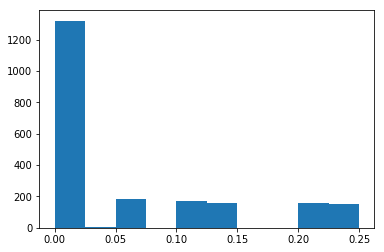

In [17]:
# an initial look at how product line items in the orders are distributed based on any discounts
plt.hist(order_detail["Discount"])
plt.show()

The vast majority of products ordered have no discount.
For ordered products that had a discount applied, the distribution into different levels of discount looks roughly equal.

The order_detail dataframe does not have any totals so I created a total for each line as that value would appear on the actual order.

In [19]:
# make a new column to calculate the line item total
order_detail['line_total'] = order_detail['Quantity'] * order_detail['UnitPrice'] * (1 - order_detail['Discount'])

order_detail.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount,line_total
0,10248/11,10248,11,14.0,12,0.0,168.0
1,10248/42,10248,42,9.8,10,0.0,98.0
2,10248/72,10248,72,34.8,5,0.0,174.0
3,10249/14,10249,14,18.6,9,0.0,167.4
4,10249/51,10249,51,42.4,40,0.0,1696.0


In [20]:
# a little more EDA, how many orders had at least one product discounted?
rs = con.execute('SELECT DISTINCT OrderId FROM OrderDetail WHERE Discount > 0')

orders_with_discount = pd.DataFrame(rs.fetchall())

orders_with_discount.columns = ['Id']

orders_with_discount.count()

2019-05-10 22:42:24,143 INFO sqlalchemy.engine.base.Engine SELECT DISTINCT OrderId FROM OrderDetail WHERE Discount > 0
2019-05-10 22:42:24,147 INFO sqlalchemy.engine.base.Engine ()


Id    380
dtype: int64

380 orders had at least one discounted product. How many orders had no discounts?

In [21]:
# make a list of orders that have no discounted items
orders_without_discount = orders.merge(orders_with_discount.drop_duplicates(), on=['Id'], how='left', indicator=True)

orders_without_discount = orders_without_discount[orders_without_discount._merge != 'both']

orders_without_discount.count()

Id                450
CustomerId        450
EmployeeId        450
OrderDate         450
RequiredDate      450
ShippedDate       440
ShipVia           450
Freight           450
ShipName          450
ShipAddress       450
ShipCity          450
ShipRegion        450
ShipPostalCode    446
ShipCountry       450
_merge            450
dtype: int64

450 orders had no discounted items. Just to check the totals, I checked the total number of orders.

In [22]:
len(orders)

830

450 orders with no discount plus 380 orders that had a discount equals 830 total orders. Now checking for any missing values in the orders table. 

In [23]:
orders.count()

Id                830
CustomerId        830
EmployeeId        830
OrderDate         830
RequiredDate      830
ShippedDate       809
ShipVia           830
Freight           830
ShipName          830
ShipAddress       830
ShipCity          830
ShipRegion        830
ShipPostalCode    811
ShipCountry       830
dtype: int64

* 19 orders have no value for ShipPostalCode.
* 21 orders have no value for ShippedDate.

To investigate the first question:

**_Do discounts have a statistically significant effect on the number of products customers order? If so, at what level(s) of discount?_**

I added four new columns to the oders table:
* order_total
* unique_products_count
* all_items_total_qty_count
* discount_flag


In [24]:
# add blank columns to orders dataframe
orders['order_total'] = 0
orders['unique_products_count'] = 0
orders['all_items_total_qty_count'] = 0
orders['discount_flag'] = False #True if order contains any discounted items, otherwise False

orders.head()

,Id,CustomerId,EmployeeId,OrderDate,RequiredDate,ShippedDate,ShipVia,Freight,ShipName,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry,order_total,unique_products_count,all_items_total_qty_count,discount_flag
0,10248,VINET,5,2012-07-04,2012-08-01,2012-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France,0,0,0,False
1,10249,TOMSP,6,2012-07-05,2012-08-16,2012-07-10,1,11.61,Toms Spezialitäten,Luisenstr. 48,Münster,Western Europe,44087,Germany,0,0,0,False
2,10250,HANAR,4,2012-07-08,2012-08-05,2012-07-12,2,65.83,Hanari Carnes,"Rua do Paço, 67",Rio de Janeiro,South America,05454-876,Brazil,0,0,0,False
3,10251,VICTE,3,2012-07-08,2012-08-05,2012-07-15,1,41.34,Victuailles en stock,"2, rue du Commerce",Lyon,Western Europe,69004,France,0,0,0,False
4,10252,SUPRD,4,2012-07-09,2012-08-06,2012-07-11,2,51.30,Suprêmes délices,"Boulevard Tirou, 255",Charleroi,Western Europe,B-6000,Belgium,0,0,0,False


In [29]:
# populate the new columns

for index, row in orders.iterrows():
    order_id = row['Id']     #row['Id'] gets the OrderId column value
    order_index = index
    
# get the relevant rows from order_detail
    temp_df = order_detail.loc[order_detail['OrderId'] == order_id]
    
    #clear the variables
    order_total = 0
    order_product_ids_count = 0
    product_ids = []
    all_items_total_qty_count = 0
    discount_flag = False
    
    # iterate through the order_detail rows and calculate the values
    for index, row in temp_df.iterrows():
        order_total += round((row['UnitPrice'] * row['Quantity']) * (1 - row['Discount']),2)
        product_ids.append(row['ProductId'])  #get the unique product id's
        all_items_total_qty_count += row['Quantity'] #count up the total # of units of all products in the order

    #check if any discount, if yes skip for this row, otherwise check if the current row has a discount
        if discount_flag == False:
            if row['Discount'] > 0:
                discount_flag = True
    
    product_ids = set(product_ids)     #make a set (unique values only) of the product id's
    
# add these values to the order in the orders dataframe
    orders.iloc[order_index, orders.columns.get_loc('order_total')] = order_total
    orders.iloc[order_index, orders.columns.get_loc('unique_products_count')] = len(product_ids)
    orders.iloc[order_index, orders.columns.get_loc('all_items_total_qty_count')] = all_items_total_qty_count
    orders.iloc[order_index, orders.columns.get_loc('discount_flag')] = discount_flag


In [30]:
orders.head()

,Id,CustomerId,EmployeeId,OrderDate,RequiredDate,ShippedDate,ShipVia,Freight,ShipName,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry,order_total,unique_products_count,all_items_total_qty_count,discount_flag
0,10248,VINET,5,2012-07-04,2012-08-01,2012-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France,440.00,3,27,False
1,10249,TOMSP,6,2012-07-05,2012-08-16,2012-07-10,1,11.61,Toms Spezialitäten,Luisenstr. 48,Münster,Western Europe,44087,Germany,1863.40,2,49,False
2,10250,HANAR,4,2012-07-08,2012-08-05,2012-07-12,2,65.83,Hanari Carnes,"Rua do Paço, 67",Rio de Janeiro,South America,05454-876,Brazil,1552.60,3,60,True
3,10251,VICTE,3,2012-07-08,2012-08-05,2012-07-15,1,41.34,Victuailles en stock,"2, rue du Commerce",Lyon,Western Europe,69004,France,654.06,3,41,True
4,10252,SUPRD,4,2012-07-09,2012-08-06,2012-07-11,2,51.30,Suprêmes délices,"Boulevard Tirou, 255",Charleroi,Western Europe,B-6000,Belgium,3597.90,3,105,True


I then split the orders table into two tables, one for orders with a discount and one for orders without a discount and checked to make sure the length of the tables matched the original SQL tables.


In [31]:
discount = orders[orders['discount_flag'] == True]
len(discount)

380

In [32]:
no_discount = orders[orders['discount_flag'] == False]
len(no_discount)

450

I wanted to first look at a scatter plot comparing orders with and without a discount.

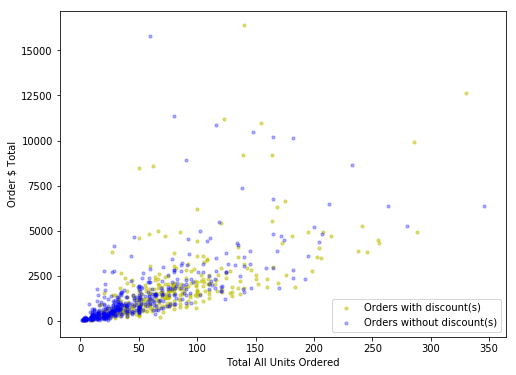

In [33]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(discount['all_items_total_qty_count'], discount['order_total'], s=10, c='y', alpha=.5, label='Orders with discount(s)')
ax.scatter(no_discount['all_items_total_qty_count'], no_discount['order_total'], s=10, c='b', alpha=.3, label='Orders without discount(s)')
ax.set_xlabel("Total All Units Ordered")
ax.set_ylabel("Order $ Total")
plt.legend(loc='lower right')

There does appear to be a correlation where orders wtih a discount tend to have a higher total units ordered. To investigate further, I need to look at the level of discount present. To do this I will need to look at the order_details table.

I could take each product in of the order_detail table and calculate the average units ordered per each level of discount. Much harder would be to do this for each individual product.

In [53]:
order_detail.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount,line_total
0,10248/11,10248,11,14.0,12,0.0,168.0
1,10248/42,10248,42,9.8,10,0.0,98.0
2,10248/72,10248,72,34.8,5,0.0,174.0
3,10249/14,10249,14,18.6,9,0.0,167.4
4,10249/51,10249,51,42.4,40,0.0,1696.0


In [89]:
order_detail['discount_group'] = 0

In [90]:
order_detail.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount,line_total,discount_group
0,10248/11,10248,11,14.0,12,0.0,168.0,0
1,10248/42,10248,42,9.8,10,0.0,98.0,0
2,10248/72,10248,72,34.8,5,0.0,174.0,0
3,10249/14,10249,14,18.6,9,0.0,167.4,0
4,10249/51,10249,51,42.4,40,0.0,1696.0,0


In [108]:
for index, row in order_detail.iterrows():
#     x = order_detail.columns.get_loc('discount_group')
#     print(x)
#     break
    if row['Discount'] < 0.05:
        order_detail.iloc[index, 7] = 1
    if row['Discount'] >= 0.05 and row['Discount'] < 0.10:
        order_detail.iloc[index, 7] = 2
    if row['Discount'] >= .1 and row['Discount'] < 0.2:
        order_detail.iloc[index, 7] = 3
    if row['Discount'] >= 0.2:
        order_detail.iloc[index, 7] = 4


In [109]:
order_detail.head(30)

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount,line_total,discount_group
0,10248/11,10248,11,14.0,12,0.00,168.00,1
1,10248/42,10248,42,9.8,10,0.00,98.00,1
2,10248/72,10248,72,34.8,5,0.00,174.00,1
3,10249/14,10249,14,18.6,9,0.00,167.40,1
4,10249/51,10249,51,42.4,40,0.00,1696.00,1
5,10250/41,10250,41,7.7,10,0.00,77.00,1
6,10250/51,10250,51,42.4,35,0.15,1261.40,3
7,10250/65,10250,65,16.8,15,0.15,214.20,3
8,10251/22,10251,22,16.8,6,0.05,95.76,2
9,10251/57,10251,57,15.6,15,0.05,222.30,2


Text(42.970593237847226, 0.5, 'Deaths')

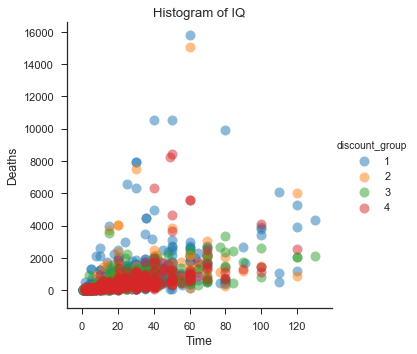

In [119]:
# Set style of scatterplot
sns.set_context("notebook", font_scale=1.1)
sns.set_style("ticks")

# Create scatterplot of dataframe
sns.lmplot('Quantity', # Horizontal axis
           'line_total', # Vertical axis
           data=order_detail, # Data source
           fit_reg=False, # Don't fix a regression line
           hue="discount_group", # Set color
           scatter_kws={"marker": "D", # Set marker style
                        "s": 100,
                         "alpha":0.5}) # S marker size

# Set title
plt.title('Histogram of IQ')

# Set x-axis label
plt.xlabel('Time')

# Set y-axis label
plt.ylabel('Deaths')

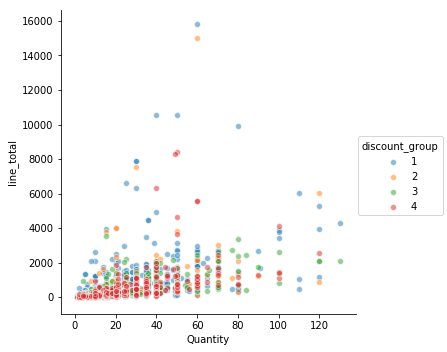

In [114]:
sns.pairplot(x_vars=["Quantity"], y_vars=["line_total"], data=order_detail, hue="discount_group", size=5, plot_kws={'alpha':0.5})

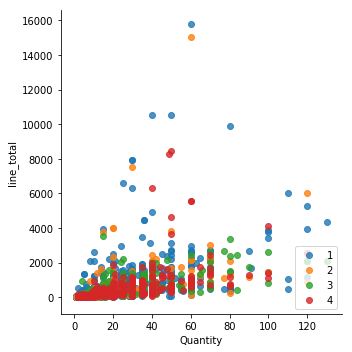

In [110]:
# fig, ax = plt.subplots(figsize=(8, 6))
sns.lmplot( x='Quantity', y='line_total', data=order_detail, fit_reg=False, hue='discount_group', legend=False)
 
# Move the legend to an empty part of the plot
plt.legend(loc='lower right')
 
#sns.plt.show()


In [ ]:
products = pd.DataFrame(['ProductId', 'avg_qty'])
for index, row in order_detail.iterrows:
    
    
    product_id = pd.DataFrame(['ProductId', 'discount', 'avg_qty'])

In [46]:
temp_df = order_detail.groupby(order_detail.ProductId)
temp_df.index = temp_df['OrderId']
temp_df.head()
    

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount,line_total
0,10248/11,10248,11,14.00,12,0.00,168.0000
1,10248/42,10248,42,9.80,10,0.00,98.0000
2,10248/72,10248,72,34.80,5,0.00,174.0000
3,10249/14,10249,14,18.60,9,0.00,167.4000
4,10249/51,10249,51,42.40,40,0.00,1696.0000
5,10250/41,10250,41,7.70,10,0.00,77.0000
6,10250/51,10250,51,42.40,35,0.15,1261.4000
7,10250/65,10250,65,16.80,15,0.15,214.2000
8,10251/22,10251,22,16.80,6,0.05,95.7600
9,10251/57,10251,57,15.60,15,0.05,222.3000


In [ ]:
for index, row in order_detail.iterrows:
    product_id = pd.DataFrame(['ProductId', 'discount', 'avg_qty'])